# Set-up

In [1]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import numpy as np
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
print(eu.settings.gpus)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

1


# Load and preprocess dataset

## From `h5py`

In [93]:
from eugene.dataload.datamodules._H5DataModule import H5DataModule

In [8]:
import h5py

In [11]:
with h5py.File(filepath, 'r') as dataset:
    print(list(dataset.keys()))

['x_test', 'x_train', 'x_valid', 'y_test', 'y_train', 'y_valid']


In [98]:
filepath = os.path.join(eu.settings.dataset_dir, "lee22", "CTCF_200.h5")
data_module = H5DataModule(filepath, batch_size=128, lower_case=True, transpose=False)

# Instantiate model

## From `EUGENe`

In [86]:
import torch
import torch.nn as nn
import eugene.models.base._blocks as blocks
import eugene.models.base._towers as towers
import eugene.models.base._layers as layers
from eugene.models import SequenceModel
class customConv(SequenceModel):
    
    def __init__(
        self,
        input_len: int,
        output_dim: int,
        strand: str = "ss",
        task: str = "binary_classification",
        aggr: str = None,
        loss_fxn: str = "bce",
        **kwargs
    ):
        super().__init__(
            input_len, 
            output_dim, 
            strand=strand, 
            task=task, 
            aggr=aggr, 
            loss_fxn=loss_fxn, 
            **kwargs
        )
        self.model = nn.Sequential()
        self.model.add_module(
            "conv_tower",
            towers.Tower(
                input_size=(4, input_len),
                block=blocks.Conv1DBlock,
                repeats=3,
                static_block_args=dict(input_len=200, dropout_rate=0.2, order="conv-norm-act-dropout-pool"),
                dynamic_block_args=dict(input_channels=[4, 64, 96], output_channels=[64, 96, 128], conv_kernel=[7, 5, 5], pool_kernel=[4, 4, 2])
            )
        )
        self.model.add_module("flatten_layer", layers.Flatten())
        self.model.add_module(
            "dense_block",
            blocks.DenseBlock(
                input_dim=np.product(conv_tower.output_size), 
                output_dim=output_dim, 
                hidden_dims=[256],
                batchnorm=True,
                batchnorm_first=True, 
                dropout_rates=0.5,
            )
        )
            
    def forward(self, x, x_rev_comp=None):
        return self.model(x)

In [87]:
model = customConv(input_len=200, output_dim=1).to("cpu")

None None binary_classification
auroc
{'task': 'binary'}
AUROC()
{'regression': {}, 'binary_classification': {'task': 'binary'}, 'multiclass_classification': {'task': 'multiclass'}, 'multilabel_classification': {'task': 'multilabel'}}


# Train model

In [89]:
import pytorch_lightning as pl

In [90]:
callback_topmodel = pl.callbacks.ModelCheckpoint(monitor='val_loss', 
                                                 save_top_k=1, 
                                                 dirpath="eugene_logs", 
                                                 filename="CTCF")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss', patience=10)

In [91]:
logger = pl.loggers.TensorBoardLogger(save_dir="eugene_logs")
trainer = pl.Trainer(gpus=1, max_epochs=100, auto_select_gpus=True, logger=logger, callbacks=[callback_es, callback_topmodel])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [99]:
# Fit to data
trainer.fit(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | train_metric | AUROC      | 0     
1 | val_metric   | AUROC      | 0     
2 | test_metric  | AUROC      | 0     
3 | model        | Sequential | 194 K 
--------------------------------------------
194 K     Trainable params
0         Non-trainable params
194 K     Total params
0.777     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

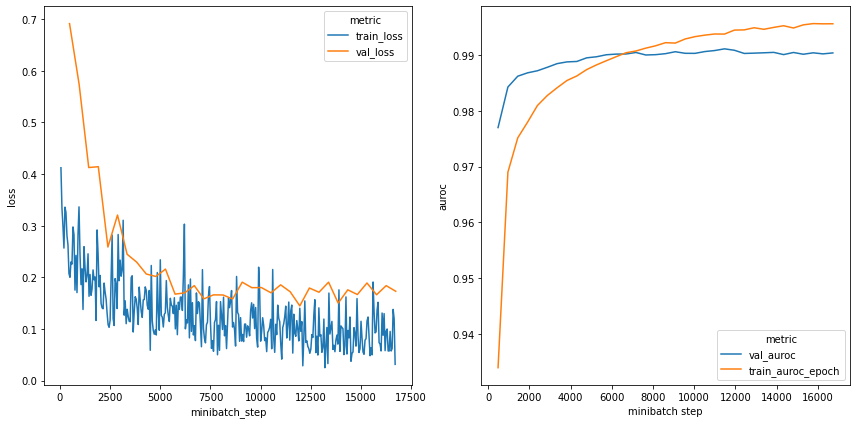

In [100]:
eu.pl.training_summary("eugene_logs/default/version_0/", metric="auroc")

# Evaluate model

In [4]:
MODEL_PATH = "/cellar/users/aklie/projects/EUGENe_use_cases/kelley16/eugene_logs/Basset.ckpt"

In [5]:
best_model = eu.models.Basset.load_from_checkpoint(MODEL_PATH)

None {'num_classes': 164} multilabel_classification
auroc
{'num_classes': 164}
AUROC()
{'regression': {}, 'binary_classification': {'task': 'binary'}, 'multiclass_classification': {'task': 'multiclass'}, 'multilabel_classification': {'task': 'multilabel'}}


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [36]:
data_module.y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
from torchvision import transforms
from eugene.dataload import ToTensor

In [46]:
sdataset = eu.dl.SeqDataset(
    seqs=data_module.x_test, 
    targets=data_module.y_test, 
    names=np.array([f"seq{i}" for i in range(len(data_module.x_test))]),
    transform=transforms.Compose([ToTensor()])
)

In [47]:
sdataset[0]

(tensor([115., 101., 113.,  48.,  36.,  36.,  36.,  36.]),
 tensor([[1., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.]]),
 tensor([-1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [48]:
sdataloader = sdataset.to_dataloader(batch_size=128, shuffle=False)

In [49]:
trainer = pl.Trainer(gpus=1, auto_select_gpus=True, logger=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [54]:
pred = np.concatenate(trainer.predict(best_model, dataloaders=sdataloader))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [64]:
preds = pred[:, 1:165].astype(np.float32)
trues = pred[:, 165:].astype(np.float32)
ids = pred[:, 1]

In [65]:
preds

array([[-4.5189333, -4.5125437, -3.7900558, ..., -3.0956502, -3.6418533,
        -4.6703386],
       [-2.5667593, -5.189077 , -2.7265296, ..., -3.2501156, -3.4317393,
        -4.0454507],
       [-6.031025 , -4.0759897, -5.158294 , ..., -3.22485  , -4.0770197,
        -4.8552556],
       ...,
       [-2.4186454, -3.8015072, -2.6640704, ..., -2.250576 , -2.9372458,
        -3.97238  ],
       [-5.2373266, -4.0637956, -4.5207825, ..., -3.826011 , -4.3333616,
        -4.6849017],
       [-2.3885746, -0.86989  , -2.1702073, ..., -2.147847 , -1.6390084,
        -2.1693165]], dtype=float32)

In [66]:
trues

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [67]:
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error
from scipy import stats
def evaluate_model(y_test, pred, task, verbose=True):
    if task == 'regression': #isinstance(pl_model.criterion, torch.nn.modules.loss.MSELoss):
        mse = calculate_mse(y_test, pred)
        pearsonr = calculate_pearsonr(y_test, pred)
        spearmanr = calculate_spearmanr(y_test, pred)
        if verbose:
            print("Test MSE       : %.4f +/- %.4f"%(np.nanmean(mse), np.nanstd(mse)))
            print("Test Pearson r : %.4f +/- %.4f"%(np.nanmean(pearsonr), np.nanstd(pearsonr)))
            print("Test Spearman r: %.4f +/- %.4f"%(np.nanmean(spearmanr), np.nanstd(spearmanr)))
        return mse, pearsonr, spearmanr

    else: 
        auroc = calculate_auroc(y_test, pred) 
        aupr = calculate_aupr(y_test, pred) 
        if verbose:
            print("Test AUROC: %.4f +/- %.4f"%(np.nanmean(auroc), np.nanstd(auroc)))
            print("Test AUPR : %.4f +/- %.4f"%(np.nanmean(aupr), np.nanstd(aupr)))
        return auroc, aupr


def calculate_auroc(y_true, y_score):
    vals = []
    for class_index in range(y_true.shape[-1]):
        vals.append( roc_auc_score(y_true[:,class_index], y_score[:,class_index]) )    
    return np.array(vals)

def calculate_aupr(y_true, y_score):
    vals = []
    for class_index in range(y_true.shape[-1]):
        vals.append( average_precision_score(y_true[:,class_index], y_score[:,class_index]) )    
    return np.array(vals)

In [68]:
results = evaluate_model(trues, preds, "binary", verbose=False)

In [70]:
aurocs = results[0]
auprs = results[1]

In [71]:
aurocs.mean(), auprs.mean()

(0.8451581652547495, 0.5309917392165966)

In [72]:
eu.external.kipoi.get_model_names("Basset")

Already up to date.


2    Basset
Name: model, dtype: object

In [73]:
kipoi_model = eu.external.kipoi.get_model("Basset")

Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/Basset/downloaded/model_files/weights/4878981d84499eb575abd0f3b45570d3


In [77]:
import torch

In [100]:
torch.Tensor(np.expand_dims(data_module.x_test, axis=3))[:1].size()

torch.Size([1, 4, 600, 1])

In [111]:
kipoi_preds = kipoi_model(torch.Tensor(np.expand_dims(data_module.x_test, axis=3))[:1000].to("cuda")).to("cpu").detach().numpy()

In [112]:
results = evaluate_model(trues[:1000], kipoi_preds, "binary", verbose=False)

In [114]:
results[1].mean()

0.6093829996690903

In [116]:
type(kipoi_model)

torch.nn.modules.container.Sequential

In [117]:
kipoi_model.modules

Sequential(
  (0): Conv2d(4, 300, kernel_size=(19, 1), stride=(1, 1))
  (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1))
  (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1))
  (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (12): Lambda()
  (13): Sequential(
    (0): Lambda()
    (1): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()